<a href="https://colab.research.google.com/github/khalilkabara/human-face-identification/blob/main/Human_Face_Identification_OGTL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-To-End Human Face Identification Regression (On Google Colab)

---

> This project and the entire notebook was built on and is intended to run Google Colab with  GPU config.

> The version of Tensor Flow used for this project is 2.2.0-rc4

> The version of Tensorflow Hub used is 0.8.0

> Other libraries used include numpy, pandas and matplotlib.

> All data will be imported from Google Drive

> A copy of this notebook is hosted on github at [link to repo](https://github.com/khalilkabara/Kaggle-Dog-Breed-Identification/blob/master/Dog_Breed_Identification_Explained.ipynb)

### 1.0 Workflow

>##### **1.1 Problem Overview**
>**Summary:** Identify the breed of a dog given it's image

>In this playground competition, you are provided a strictly canine subset of ImageNet in order to practice fine-grained image categorization. How well you can tell your Norfolk Terriers from your Norwich Terriers? With 120 breeds of dogs and a limited number training images per class, you might find the problem more, err, ruff than you anticipated.

>This problem was hosted on Kaggle at [competition url](https://www.kaggle.com/c/dog-breed-identification/)

>##### **1.2 Data**
>You are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal of the competition is to create a classifier capable of determining a dog's breed from a photo.

>More at: https://www.kaggle.com/c/dog-breed-identification/data

>##### **1.3 Modelling**
>For this peoject, we are going to use Google's Tensorflow

>##### **1.4 Evaluation**
>Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.

>Submission File: For each image in the test set, you must predict a probability for each of the different breeds. The file should contain a header and have the following format:

>id,affenpinscher,afghan_hound,..,yorkshire_terrier
000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
etc.

>**Multi-Class-Log-Loss:** Multi-class logarithmic loss function per class. ... The cost function F measures the distance between two probability distributions, i.e. how similar is the distribution of actual labels and classifier probabilities. Hence, values close to zero are preferred. More at https://stats.stackexchange.com/questions/113301/multi-class-logarithmic-loss-function-per-class

>More at: https://www.kaggle.com/c/dog-breed-identification/overview/evaluation


>##### **1.5 Features**
>You are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal of the competition is to create a classifier capable of determining a dog's breed from a photo.

>More at: https://www.kaggle.com/c/dog-breed-identification/data

## 2.0 Import Libraries And Get Workspace Ready
> Import TensorFlow into colab

> Ensure we are running TF v 2.0 and above

> Import Tensorflow Hub

> Ensure we are running on a GPU

In [ ]:
# Import TensorFlow into colab

import tensorflow as tf

In [ ]:
# Check TF version

print("TF version: ", tf.__version__)

TF version:  2.3.0


In [ ]:
# Import Tensorflow Hub

import tensorflow_hub as hub
print("TF Hub version: ", hub.__version__)

TF Hub version:  0.10.0


In [ ]:
# Check if GPU is available

print("GPU", "available." if tf.config.list_physical_devices("GPU") else "not available")

# If GPU not available, setup GPU in notebook settings under toolbar > runtime > change runtime type

GPU available.


## 3.0 Import Data

>Connect to google drive

>Locte directory containing files

In [ ]:
# Import Data Into Colab (Or Use Google Drive As Indicated In The Next Cell).
# Note that when done this way, data will be loast each time colab runtime is restarted.
# An alternative is to store and use data in google drive as indicated in the next cell.
# Doing it this way also involves downloading kaggle cookie file using a tool like cookies.txt chrome extension and importing into colab
# Unzip zipped data.

# In the line below, cookies.txt is the downloaded kaggle cookie file in txt format.
#  "https://www.kaggle.com/c/7327/download-all" is the url of the dataset on kaggle
# !wget -x --load-cookies cookies.txt "https://www.kaggle.com/c/7327/download-all" -O data.zip

# Unzip zipped data
# !unzip data.zip

In [ ]:
# Authorize Google Drive Mount So That We Can Access Google Drive Data From Colab
# Do not orget to re-mount drive when colab reconnects

from google.colab import drive
def mount_drive():
  drive.mount('/content/drive')

# Uncomment function call to initiate google drive mount, copy authorization token and paste in the text box that appears.
mount_drive()

Mounted at /content/drive


In [ ]:
# Unzip Files In Google Drive

# !unzip "/content/drive/My Drive/SWDEV/Data/Dog Breed Identification - Kaggle/data.zip" -d "/content/drive/My Drive/SWDEV/Data/Dog Breed Identification - Kaggle/data_unzipped"

## 4.0 Get Data Ready
> Turn data into tensors for use with Tensorflow

> View and Explore image data

> **NOTE:** We have stored all data in google drive. Alter path_to_files variable to point to the drive location where you have stored your data

### 4.1 Create Helper Strings And Import Pandas

In [ ]:
# Create Helper Strings That Point To File Paths Since Paths Are Pretty Long

path_to_files = "drive/My Drive/SWDEV/Data/Dog Breed Identification - Kaggle/data_unzipped/"

test_data_path = path_to_files + "test/"
train_data_path = path_to_files + "train/"
labels_path = path_to_files + "labels.csv"
sample_submission_path = path_to_files + "sample_submission.csv"

In [ ]:
# Import Pandas

import pandas as pd

### 4.2 Get And Explore Labels Data

In [ ]:
# Check out data labels

labels_csv = pd.read_csv(labels_path)
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
# Describe labels

labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     bf904a3e0ad73be75221a5fc271bece6  scottish_deerhound
freq                                   1                 126

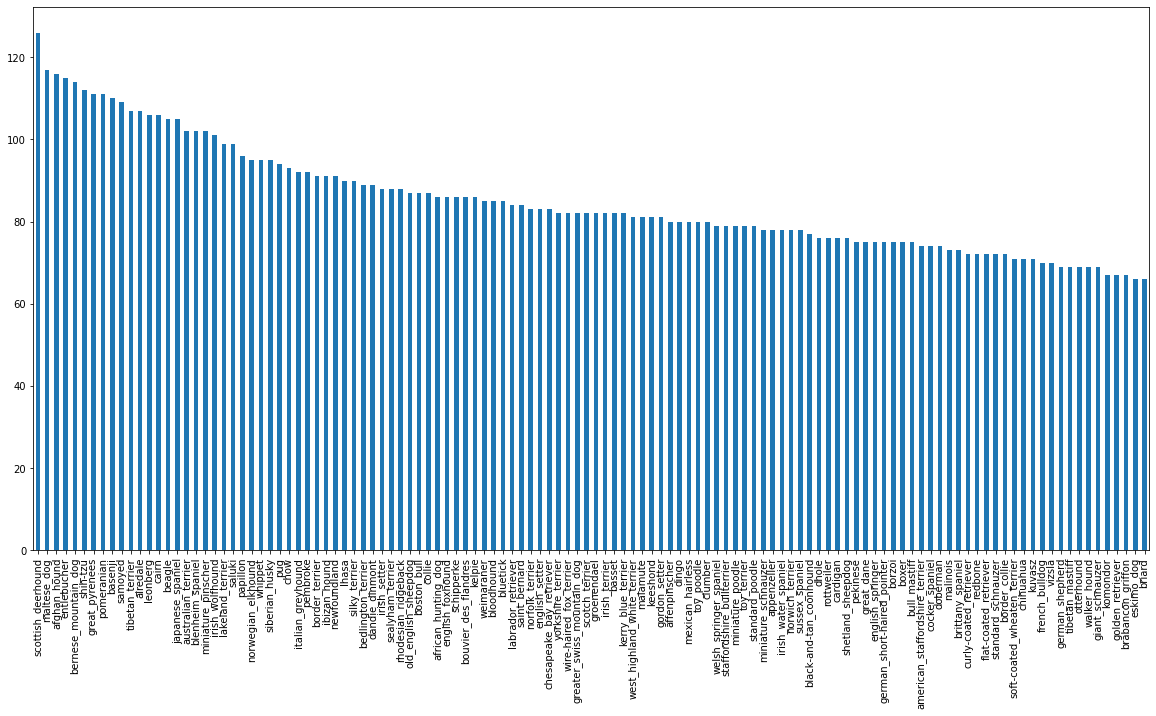

In [ ]:
# Visuaize the different breeds that are in our data

labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10));

### 4.3 Get And Explore Images Data

In [ ]:
# check if number of labels matches number of filenames

import os

filenames = [train_data_path + fname + ".jpg" for fname in labels_csv['id']]

if len(os.listdir(train_data_path)) == len(filenames):
  print("Number of labels matches number of files. You may proceed")
else:
  print("Filenames do NOT match number of files in directory. Check data directories before proceeding")

Number of labels matches number of files. You may proceed


In [ ]:
# View an image
# Create a handy function for viewing images given image id's

from IPython.display import Image

def view_image_by_id(image_id, directory='train'):
  """
  A handy function for viewing dog image files in our notebook. Expects image_id
  """
  if directory == 'test':
    return Image(test_data_path + image_id + ".jpg")
  else:
    return Image(train_data_path + image_id + ".jpg")

In [ ]:
# Create another function for viewing train data images given an index

def view_image_by_index(index=0):
  if index <= len(filenames):
    return Image(filenames[index])
  else:
    print(f"There is no Image at index {index}. Returning first image")
    return Image(filenames[0])

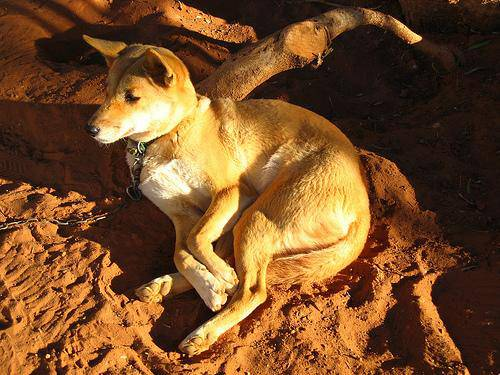

In [ ]:
# View a dog image by id

view_image_by_id("001513dfcb2ffafc82cccf4d8bbaba97")

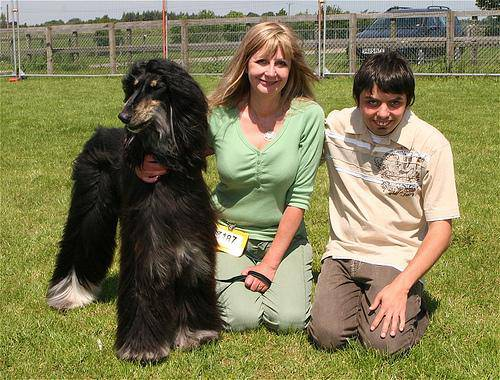

In [ ]:
# View a dog image by index (from train data)
view_image_by_index(1200)

### 4.4 Convert Labels Into Numeric Values Using Numpy

In [ ]:
# Convert labels into numbers

import numpy as np
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
# check if number of labels matches number of filenames

if len(labels) == len(filenames):
  print("Number of labels matches number of files. You may proceed")
else:
  print("Number of labels do NOT match number of files. Check data directories before proceeding")

Number of labels matches number of files. You may proceed


In [ ]:
# Find the unique label values. Print first 20

unique_breeds = np.unique(labels)
unique_breeds[:20]

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull'], dtype=object)

In [ ]:
#Turn every label into a boolean array. View only first otwo

boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
# One hot encode boolean arrays into integers

### 4.5 Split Training Data into Train And Valid Dataset
Since the dataset from kaggle does not come with a validation set, we are going to create our's.

We are goint to start off experimenting with 1000 images and increase as needed.

In [ ]:
# Set up x and y variables

x = filenames
y = boolean_labels

In [ ]:
# Set number of images to use for experimenting

NUM_IMAGES = 1000 #@param {type: "slider", min: 1000, max: 10000, step: 1000}

In [ ]:
# Split data into train and validation using train_test_split

from sklearn.model_selection import train_test_split

# Do split into training and validation sets of total size equals to NUM_IMAGES

x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES], 
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2, 
                                                  random_state=42)
len(x_train), len(y_train), len(x_val), len(y_val)

(800, 800, 200, 200)

### 4.6 Convert Image Data Into Tensors (Numeric Representations)

To preprocess our images into tensors, we will write a function which does the following:
> 1. Take an image file path as input.

> 2. Use tensorflow to read the file and save it to a variable, `image`.

> 3. Turn our `image` (a jpg) into Tensors.

> 4. Normalize our image (Convert color channel values from 0 to 255 to a float between 0 and 1)

> 4. Resize `image` to be a shape of (224, 224)

> 5. Return the modified `image`.

Before proceeding, lets see what importing and converting an image into a tensor looks like

In [ ]:
# Convert an image into a numpy array

from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
# Convert an image into a tensor

tf.constant(image)[:1]

<tf.Tensor: shape=(1, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]]], dtype=uint8)>

In [ ]:
# First, let's see what converting an image into a tensor looks like

# tensor = tf.io.read_file(filenames[42])
# String too long, uncomment to view
# tensor

In [ ]:
# Create a function that converts images into tensors

# Define image size. We use 224 because the model we are going to use was trained on size (224, 224)
IMAGE_SIZE = 224

# Define our function
def image_to_tensor(image_path, image_size=IMAGE_SIZE):
  """
  Takes an image file path and turns it into a tensor
  """
  # Read image file
  image = tf.io.read_file(image_path)
  # Turn the jpg image into numerical tensor with 3 color channels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 values (Normalization)
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size of (224, 224)
  image = tf.image.resize(image, size=[image_size, image_size])
  # Return preprocessed image
  return image

In [ ]:
# Test our function

image_to_tensor(filenames[42])[:2]

<tf.Tensor: shape=(2, 224, 3), dtype=float32, numpy=
array([[[0.3264178 , 0.5222886 , 0.3232816 ],
        [0.2537167 , 0.44366494, 0.24117757],
        [0.25699762, 0.4467087 , 0.23893751],
        ...,
        [0.29325107, 0.5189916 , 0.3215547 ],
        [0.29721776, 0.52466875, 0.33030328],
        [0.2948505 , 0.5223015 , 0.33406618]],

       [[0.25903144, 0.4537807 , 0.27294815],
        [0.24375686, 0.4407019 , 0.2554778 ],
        [0.2838985 , 0.47213382, 0.28298813],
        ...,
        [0.2785345 , 0.5027992 , 0.31004712],
        [0.28428748, 0.5108719 , 0.32523635],
        [0.28821915, 0.5148036 , 0.32916805]]], dtype=float32)>

### 4.7 Turn Our Data Into Batches

TensorFlow works really well with batches.

**Question:** Why turn our data into batches?

**Answer:** Say for example we are trying to process 10,000+ images in one go... They might not all fit into memory. Though very fast, the GPU we are processing data on still has limited memory. That's why we do about 32 images (batch size) at a time. Can be manually adjusted if needed.

In order to use Tensorflow effectively, we need to get our data in the form of tensor tuples which look like this: `(image, label)`

In [ ]:
# Create a simple function that return a tuple of image and label

def get_image_and_label(image_path, label):
  """
  Takes an image file path and it's associated label, processes the image (converts into tensors) then returns a tuple of (image, label)
  """
  return image_to_tensor(image_path), label

In [ ]:
get_image_and_label(x[42], y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [ ]:
# Create a function that turns all data (x and y that can now be returned in tensors) into batches
# Define batch size, 32 for now. Adjustable
BATCH_SIZE = 32 #@param {type: "slider", min: 32, max: 64, step: 8}


In [ ]:
# Define function

def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and labels (y) pairs.
  It shuffles the data if it's training data, but doesn't for validation data.
  Also accepts test data as input (no labels).
  """
  # If data is test dataset, there won't be labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # Only filepaths, no labels
    # Map to image_to_tensor function
    data_batch = data.map(image_to_tensor).batch(batch_size)
    return data_batch
  # If data is valid dataset, we do not need to shuffle it
  elif valid_data:
    print("Creating valid data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # File paths
                                               tf.constant(y))) # Labels
    # Map to get_image_and_label function
    # Create (image, label) tuples. This also turns the image path into a processed image by calling image_to_tensor
    data = data.map(get_image_and_label)
    # Turn data into batches
    data_batch = data.batch(batch_size)
    return data_batch
  # If data is train dataset
  else:
    print("Creating training data batches...")
    # Turn file paths and labels into tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # File paths
                                               tf.constant(y))) # Labels
    # Shuffling pathnames and labels before mapping image_to_tensor function is faster than shuffling images after mapping
    data = data.shuffle(buffer_size=len(x))
    # Map to get_image_and_label function
    # Create (image, label) tuples. This also turns the image path into a processed image by calling image_to_tensor
    data = data.map(get_image_and_label)
    # Turn data into batches
    data_batch = data.batch(batch_size)
    return data_batch

In [ ]:
# Test function by creating training and validation data batches

train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)
train_data, val_data

Creating training data batches...
Creating valid data batches...


(<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>,
 <BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>)

In [ ]:
# Explore newly created data batches

train_data.element_spec, val_data.element_spec
# Images shape=(None, 224, 224, 3) means:
# None for batch size (since it's flexible)
# 224 and 224 for width and height respectively
# And 3 color channels (RGB)

# Then labels shape=(None, 120) means:
# None for batch size (since it's flexible)
# And dimension of 120 (Since there are 120 different dog breeds)

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### 4.8 Explore And Visualize Data Batches

In [ ]:
# Explore and visualize batches

import math
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def view_databatch_images(images, labels, quantity=25):
  """
  Displays a plot of images and their labels from a data batch.
  Quantity can not be greater than 32 since our batch size is 32
  """
  if quantity > BATCH_SIZE:
    quantity = BATCH_SIZE
    
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through quantity for displaying that amount of images
  for i in range(quantity):
    # Determine num rows
    n_rows = math.ceil(quantity/5) if quantity/5 > 1 else 1
    # Create subplots (max of 5 columns and adequate rows)
    ax = plt.subplot(n_rows,5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [ ]:
# Unbatch training data so that it can be visualized with help of our handy function
# Training data will shuffle each time we run this cell because we shuffle our training data each time we process it for adding into batches

train_images, train_labels = next(train_data.as_numpy_iterator())

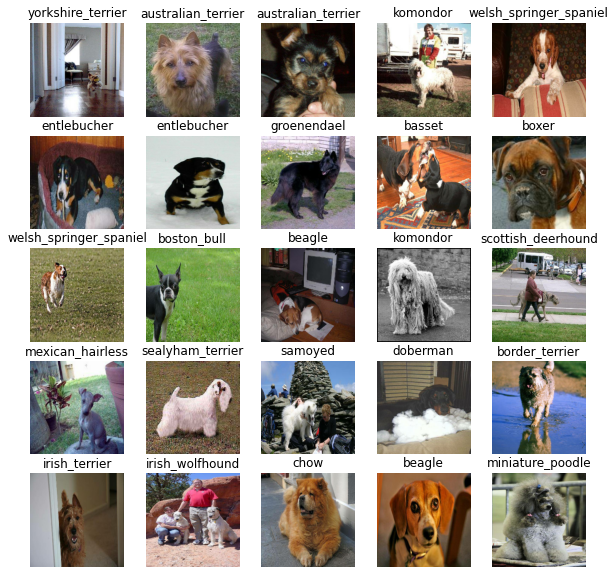

In [ ]:
# Visualize data in a training batch

view_databatch_images(train_images, train_labels, 25)

In [ ]:
# Unbatch validation data so that it can be visualized with help of our handy function
val_images, val_labels = next(val_data.as_numpy_iterator())

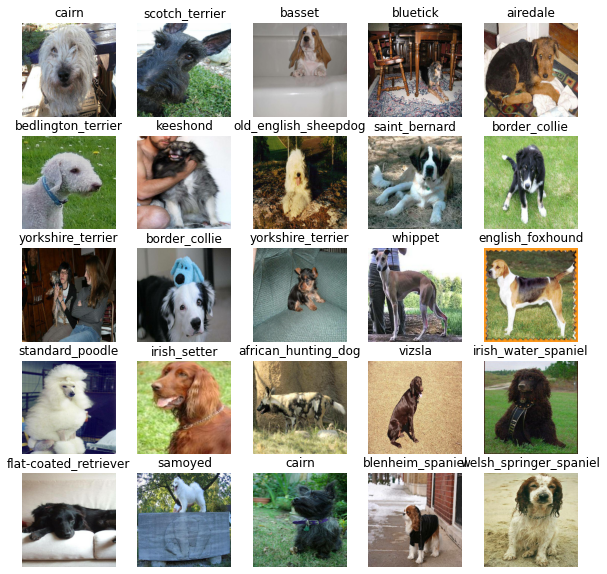

In [ ]:
# Visualize data in a validation batch

view_databatch_images(val_images, val_labels, 25)

## 5.0 Modelling

There are several ways to build a deep learning model. For this problem, we will be using transfer learning. We will use an existing model then improve once we have our baseline results.

Before building a model, we need to define the following

* The input shape (our images in the form of tensors)

* The output shape (image labels in the form of tensors)

* The URL of the model we will be using from TensorFlow Hub. [Mobilenet v2.130.224](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4)

### 5.1 Preparing Inputs And Outputs

In [ ]:
# Setup input shape
# IMAGE_SIZE is 224 because the model we will be using was trained on images of that size
INPUT_SHAPE = [None, IMAGE_SIZE, IMAGE_SIZE, 3] # batch, height, width, color channels
# Setup output shape
OUTPUT_SHAPE = len(unique_breeds)
# Setup model url from TensorFlow Hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

#### Create a function that creates a model using TF Keras API (Sequental API since it's easier to implement)

Create a function which:
* Takes the input shape, output shape nd model we've chosen as params.
* Defines the layers in a Keras model in a sequential fashion (one after the other).
* Compiles the model (says how it should be evaluated and improved)
* Builds the model (tells the model the inut shape it'll be getting)
* Retuns the model.

More on these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [ ]:
# Create a function which builds a keras model

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with: ", model_url)
  # Setup model layers
  model = tf.keras.Sequential([
                             hub.KerasLayer(model_url), # Layer 1 (input layer)
                             tf.keras.layers.Dense(units=output_shape,
                                                   activation='softmax') # Layer 2 (output layer)
  ])
  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )
  # Build model
  model.build(input_shape)
  return model

In [ ]:
# Test model creation and view model summary

model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


### 5.2 Create Callbacks

> Callbacks are helper functions a model can use during training to do such things as:
* Check it's progress.
* Save it's progress.
* Stop training early if a model stops improving so as to prevent overfitting.

> We will create 2 callbacks for this problem:
* One for `TensorBoard` which helps tracks our model's progress.
* Another for early stopping which prevents our model for training for too long and prevents.

> To setup a `TensorBoard` callback, we need to do the following
* Load the `TensorBoard` notebook extension.
* Create a `TensorBoard` callback which is able to save logs to a directory and pass it to our model's `fit()` function.
* Visualize our model's training logs with the `%tensorboard` magic function (after model training).

> Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [ ]:
# 1. TensorBoard callback

# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# Import datetime for track each experiment
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  LOG_DIR_PATH = 'drive/My Drive/SWDEV/Colab Notebooks/dog_breed_identification/logs'
  log_dir = os.path.join(LOG_DIR_PATH,
                         # Make it so the logs get tracked whenever we run experiments
                         datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  return tf.keras.callbacks.TensorBoard(log_dir)

In [ ]:
# 2. Create an early stopping callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) #3 epochs

### 5.3 Train Model (On A Subset Of Data)

Our first model is only going to train on 1,000 images to make sure everything is working.

* Create a simple function which trains a model.

* Create a model using `create_model()`.

* Setup a TensorBoard callback using `create_tensorboard_callback()`.

* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for `NUM_EPOCHS` and the callbacks we'd like to use.

* Return the model.

In [ ]:
# Define number of epochs. 
# One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE.
# One epoch would be giving our model a single chance to look at all of the training data and then validate.

NUM_EPOCHS = 100 #@param{type: "slider", min: 10, max: 100, step: 10}


In [ ]:
# Ensure we are still running on a gpu

print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")
# If GPU not available, setup GPU in notebook settings under toolbar > runtime > change runtime type

GPU available


In [ ]:
# Create a simple function which trains a model and returns it

def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create model
  model = create_model()
  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()
  # tensorboard = tf.keras.callbacks.TensorBoard('/drive/My Drive/SWDEV/Colab Notebooks/dog_breed_identification/logs/test')
  # Fit the model to the data passing it the callbacks we created.
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [ ]:
%time
# Fit model to the data
# model = train_model()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


It looks like our model is overfitting because it is performing far bettter on the training dataset than on the validation dataset. What are some ways to prevent model overfitting in deep learning neural networks?

**NOTE:** *Overfitting to begin with is a good thing. It means our model is actually learning.*

---


Checking TensorBoard logs.
The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize it's contents.

In [ ]:
# Directory for saving models for saving model
models_dir = 'drive/My Drive/SWDEV/Colab Notebooks/dog_breed_identification/trained_models/initial'

In [ ]:
# Save and load model to file to save long training time during re-runs

# model.save(models_dir)
model = tf.keras.models.load_model(models_dir)

In [ ]:
# View logs, escaping space characters
%tensorboard --logdir drive/My\ Drive/SWDEV/Colab\ Notebooks/dog_breed_identification/logs

<IPython.core.display.Javascript object>

## 6.0 Prediction And Evaluation
Making and evaluating predictions using a trained model

#### Making Predictions On The Validation Data (Not Used To Train On)

>`predict` in TensorFlow is similar to `predict_proba` in sklearn. It produces an array of probabilities of the data being of each of the unique classes. These probabilities are also called confidence intervals.

In [ ]:
# Make predictions on validation data
predictions = model.predict(val_data, verbose=1) # Set verbose=1 to view progress bar

# View predictions...

# For this problem, this produces an array of size 200 (size of validation data).
# Each element of the main array is another array of size 120 (number of unique breeds)
# For each prediction contains probability of an image being of one of the elements of unique_breeds
# This is similar to `predict_proba` in scikit learn
predictions

7/7 [==============================] - 109s 16s/step


array([[1.7522242e-03, 3.5717083e-05, 1.1560153e-03, ..., 2.1396291e-04,
        1.5600530e-05, 5.4691429e-03],
       [6.9006942e-03, 7.4969890e-04, 7.6088612e-03, ..., 5.6069084e-03,
        3.4364513e-03, 2.0834139e-04],
       [1.1481080e-06, 7.3725814e-06, 4.4649723e-06, ..., 3.7146199e-06,
        1.0474265e-05, 7.2153116e-04],
       ...,
       [2.1899632e-06, 2.5897525e-05, 7.0957858e-06, ..., 6.4664982e-07,
        8.5740983e-05, 1.1983474e-04],
       [2.1005210e-03, 8.0602906e-05, 1.4843054e-04, ..., 1.3207049e-04,
        3.6960919e-05, 2.9580258e-03],
       [8.4390928e-04, 3.0659448e-05, 9.3206494e-05, ..., 1.3140638e-04,
        5.0433929e-04, 1.9585403e-05]], dtype=float32)

In [ ]:
# The sum of all probalities in any prediction amounts to a value very close to 1. 
# This is because we've used a softmax activation function
np.sum(predictions[3])

1.0000001

In [ ]:
# Check length of the predictions, then compare with length of validation labels
predictions.shape, len(y_val)
index_to_test = 5

In [ ]:
# The max probability for the first prediction is:
np.max(predictions[index_to_test])

0.94096595

In [ ]:
# Index of the highest probability is (17 for this run):
np.argmax(predictions[index_to_test])
# This means that the model thinks that the image in predictions[0] is of class unique_breeds[17]
# Again, the number 17 is for this run and might change when model is re-trained

10

In [ ]:
# Now check unique_breeds[17]
unique_breeds[np.argmax(predictions[index_to_test])]
# Our model thinks the image at val_data[0] is a sample of 'border_terrier'

'bedlington_terrier'

In [ ]:
# Create a function for exploring predictions
# Create another function that builds our return dict so we don't have to do it twice (once for exploring single pred and another time for exploring all preds)
# This function can be simplified, but doing it this way makes it self explanatory

def explore_predictions(preds=predictions, index=0, explore_all=False):
  if not explore_all:
    return populate_result(preds, index)

  else:
    result = []
    for index, pred in enumerate(preds):
      entry = {}
      entry['Index'] = index
      entry.update(populate_result(preds, index))
      result.append(entry)

  return result

def populate_result(preds, index):
  result = {}
  result['Proba Sum'] = np.sum(preds[index])
  result['Max Probability'] = np.max(preds[index])
  result['Highest Probability Index'] = np.argmax(preds[index])
  result['Prediction Label'] = unique_breeds[np.argmax(preds[index])]

  return result

In [ ]:
# Test one
pd.Series(explore_predictions(index=22))

Proba Sum                           1
Max Probability              0.739237
Highest Probability Index          26
Prediction Label                cairn
dtype: object

In [ ]:
# Test all
preds_df = pd.DataFrame(explore_predictions(explore_all=True))
preds_df.tail(5)

Index  Proba Sum  ...  Highest Probability Index  Prediction Label
195    195        1.0  ...                         87        pomeranian
196    196        1.0  ...                         33            collie
197    197        1.0  ...                         15          bluetick
198    198        1.0  ...                         73       maltese_dog
199    199        1.0  ...                         27          cardigan

[5 rows x 5 columns]

In [ ]:
# Unbatch validation data
# Note, instead of unbatching data, we could just use x_val and y_val data that we already have
# However, we want to learn how to unbatch data

def unbatchify(data):
  """
  Takes a batched dataset (image, label) tensors and returns separate arrays of images and labels
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(label)
  return images, labels

unbatched_val_images, unbatched_val_labels = unbatchify(val_data)

In [ ]:
# Define a function for getting label name from label data

def get_pred_label(index):
  return unique_breeds[np.argmax(unbatched_val_labels[index])]

In [ ]:
# Create a dataframe of labels as strings

actual_val_labels = []
for index, row in enumerate(unbatched_val_labels):
  actual_val_labels.append(get_pred_label(index))
  
actual_df = pd.DataFrame(data={'label': actual_val_labels})
actual_df.tail()

label
195         pomeranian
196  shetland_sheepdog
197           bluetick
198        maltese_dog
199        appenzeller

In [ ]:
# Compare predicted to actual labels

pred_comparisons = preds_df["Prediction Label"] == actual_df['label']
pred_comparisons.value_counts()

True     136
False     64
dtype: int64

In [ ]:
# Check accuracy
(135/200)
# Same with our models training accuracy. Perfect!

0.675

#### View And Explore Unbatched Images

In [ ]:

# Create a function for viewing images along with our model's predictions
def view_unbatched_images(images, labels, quantity=25):
  """
  Displays a plot of images and their labels.
  Quantity can not be greater than size of images or labels
  """
  # Check if image size match label size
  if not len(images) == len(labels):
    print(f"Images size {len(images)} does not match labels size {len(labels)}. Can not plot...")
    return None

  if quantity > len(images):
    quantity = len(images)
  
  print(f"Viewing {quantity} images...")

  # Setup the figure
  plt.figure(figsize=(15, 15))
  # Loop through quantity for displaying that amount of images
  for i in range(quantity):
    cols = 3
    # Determine num rows
    n_rows = math.ceil(quantity/cols) if quantity/cols > 1 else 1
    # Create subplots (max of cols columns and adequate rows)
    ax = plt.subplot(n_rows, cols, i+1)
    # Display an image
    plt.imshow(images[i])
    # Change color of the title depending on if the prediction is right or wrong
    # Green is right, Red is wrong
    color = 'green' if preds_df['Prediction Label'][i] == actual_df['label'][i] else 'red'
    # Add the image label as the title
    plt.title("{} ({:2.0f}% {})".format(unique_breeds[labels[i].argmax()], 
                                        preds_df['Max Probability'][i]*100, 
                                        preds_df['Prediction Label'][i]),
              color=color)
    # Turn the grid lines off
    plt.axis("off")

Viewing 21 images...


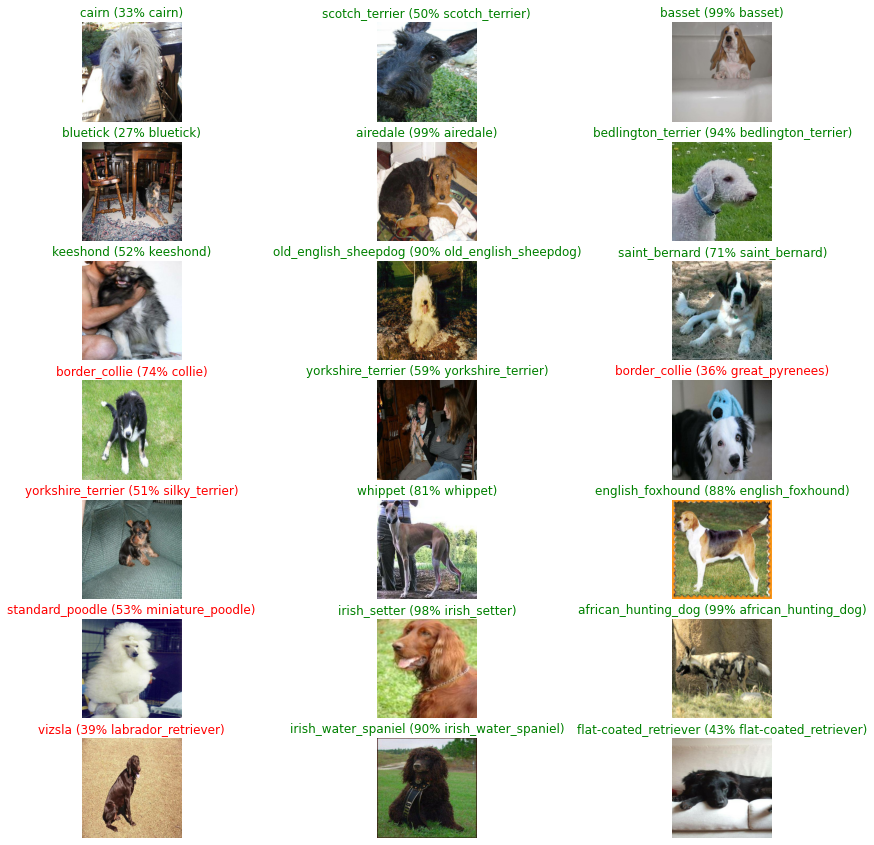

In [ ]:
view_unbatched_images(unbatched_val_images, unbatched_val_labels, 21)

In [ ]:
def view_top_10_predictions():
  top_10 = preds_df.sort_values(by='Max Probability', ascending=False)[:10]
  # view_unbatched_images(top_10['Highest Probability Index'])
  top_10.plot('Prediction Label', 'Max Probability', kind='bar')

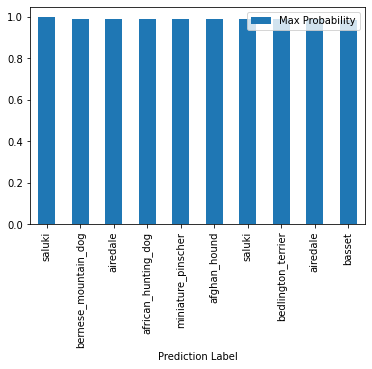

In [ ]:
view_top_10_predictions()

## 7. Create A Confusion Matrix
Create a confusion matrix with our predicted and actual labels to find out where our model is getting confused

In [ ]:

actual_val_labels_tensors = []
for i, row in enumerate(unbatched_val_labels):
  actual_val_labels_tensors.append(np.argmax(row))
  
# actual_val_labels_tensors

conf_mat = tf.math.confusion_matrix(predictions=preds_df['Highest Probability Index'], labels=actual_val_labels_tensors)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


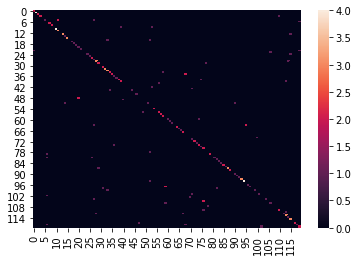

In [ ]:
import seaborn as sns
sns.heatmap(conf_mat);

## 8.0 Properly Save And Load Models

In [ ]:
# Create a function for saving model
models_dir = 'drive/My Drive/SWDEV/Colab Notebooks/dog_breed_identification/trained_models'
def save_model(model, suffix=None, models_dir=models_dir):
  """
  Saves a model in a models directory and appends a suffix
  """
  save_path = os.path.join(models_dir, 
                           datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  save_path += "-"
  save_path += suffix
  save_path += ".h5" # Model's save format
  print(f"Saving model to: {save_path}")
  model.save(save_path)
  return save_path

In [ ]:
# Create a function to load a model
def load_model(model_path):
  """
  Loads a saved model from a specified path
  """
  print(f"Loading saved model from {model_path}")
  return tf.keras.models.load_model(model_path,
                                    custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
# Test save and load
# Save
# save_model(model, "1000-images-mobilenetv2-Adam")

# Load
model = load_model('drive/My Drive/SWDEV/Colab Notebooks/dog_breed_identification/trained_models/20200517-185701-1000-images-mobilenetv2-Adam.h5')

Loading saved model from drive/My Drive/SWDEV/Colab Notebooks/dog_breed_identification/trained_models/20200517-185701-1000-images-mobilenetv2-Adam.h5


In [ ]:
# Evaluate pre-loaded model
model.evaluate(val_data)

7/7 [==============================] - 1s 111ms/step - loss: 1.2466 - accuracy: 0.6800


[1.2466236352920532, 0.6800000071525574]

## Train Model On Full Dataset

In [ ]:
# We already have all our data split into x and yx[:10]
len(x), len(y)

(10222, 10222)

In [ ]:
# Turn images and labels to tensors
# Create a databatch with full dataset
full_data = create_data_batches(x=x, y=y)

Creating training data batches...


In [ ]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
# Create a model for full modelling
full_model = create_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:
%time
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on full data, so we can not monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                             patience=3)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [ ]:
%time
# Fit the full model to the full data
# Running this cell will take a long while. Up to 20 mins on fast computers
# Uncomment to fit

# full_model.fit(x=full_data,
#                epochs=NUM_EPOCHS,
#                callbacks=[full_model_tensorboard, full_model_early_stopping])

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


In [ ]:
# After 22 epochs, our early_stopping kicked in and training was stopped.
#Let's now save this model to save on training time.

# save_model(model=full_model, suffix="10222-images-full-model")

In [ ]:
# Load saved model

full_model = load_model('drive/My Drive/SWDEV/Colab Notebooks/dog_breed_identification/trained_models/20200517-212121-10222-images-full-model.h5')

Loading saved model from drive/My Drive/SWDEV/Colab Notebooks/dog_breed_identification/trained_models/20200517-212121-10222-images-full-model.h5


## 9.0 Make Predictions On Test Dataset

Since our model has been trained on images in the form of Tensor Batches, to make predictions on the test data, we will have to get it into the same format.

> Import test data.

> Process Data (Batchify)

> Make predictions on test data batch

### Continue Train

In [ ]:
# load test dataset

test_filenames = [test_data_path + fname for fname in os.listdir(test_data_path)]
test_filenames[:10]

['drive/My Drive/SWDEV/Data/Dog Breed Identification - Kaggle/data_unzipped/test/e27567e188000db387977cdb9bbdcf82.jpg',
 'drive/My Drive/SWDEV/Data/Dog Breed Identification - Kaggle/data_unzipped/test/e504cbd0094fc72312087587795be597.jpg',
 'drive/My Drive/SWDEV/Data/Dog Breed Identification - Kaggle/data_unzipped/test/e0bf90705facb623a6f36046cc495659.jpg',
 'drive/My Drive/SWDEV/Data/Dog Breed Identification - Kaggle/data_unzipped/test/e3982348ad8b974cef2298f741bc3c99.jpg',
 'drive/My Drive/SWDEV/Data/Dog Breed Identification - Kaggle/data_unzipped/test/e218c0da622fedc975a97999ad7d48a5.jpg',
 'drive/My Drive/SWDEV/Data/Dog Breed Identification - Kaggle/data_unzipped/test/e1cfddc1d5315f1dba011c6152822786.jpg',
 'drive/My Drive/SWDEV/Data/Dog Breed Identification - Kaggle/data_unzipped/test/e42105cc55af6788d3c15473c562dc77.jpg',
 'drive/My Drive/SWDEV/Data/Dog Breed Identification - Kaggle/data_unzipped/test/e2b24cea9d0796ffad73cb24eab1a3f6.jpg',
 'drive/My Drive/SWDEV/Data/Dog Breed Id

In [ ]:
len(test_filenames)

10357

In [ ]:
# Convert to test data batches

test_data = create_data_batches(x=test_filenames, test_data=True)
test_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [ ]:
%time
# Running this will take a very long time to run. About an hour
# Make predictions on test data batch using loaded full model
# Uncomment to run

# test_preds = full_model.predict(test_data,
#                                 verbose=1)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


### Save And Load Test Preds

In [ ]:
# Save predictions to csv file for access later
# Uncomment to save

# np.savetxt('drive/My Drive/SWDEV/Colab Notebooks/dog_breed_identification/dog_breed_identification_test_preds.csv',
#            test_preds,
#            delimiter=',')

In [ ]:
# Load from saved file

preds_path = 'drive/My Drive/SWDEV/Colab Notebooks/dog_breed_identification/dog_breed_identification_test_preds.csv'
test_preds = pd.read_csv(preds_path)

# Or
# test_preds = np.loadtxt(preds_path, delimeter=',')

In [ ]:
test_preds.head()

id  ...  yorkshire_terrier
0  ea5ae600ca3996528b6548eceac767cf  ...       1.521617e-06
1  eb61a828e939eb633c1811f283d15647  ...       2.569809e-10
2  efb4e5dc776a639a140b022cf0835eb5  ...       7.418608e-11
3  f16f47570b2ef2c21c54eb1478518e8f  ...       6.134530e-11
4  eb3849def6fa245bcaae9ab9c64f024f  ...       1.318874e-06

[5 rows x 121 columns]

In [ ]:
test_preds.shape

(1374, 121)

## 10.Preparing Test Dataset Predictions For Kaggle
Looking at the Kaggle sample submission, it looks like they want the models output probabilities each for label along with the image ID's.

To get the data in this format, we'll:

> Create a pandas DataFrame with an ID column as well as a column for each dog breed.

> Add data to the ID column by extracting the test image ID's from their filepaths.

> Add data (the prediction probabilities) to each of the dog breed columns using the unique_breeds list and the test_predictions list.

> Export the DataFrame as a CSV to submit it to Kaggle.

In [ ]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [ ]:

# Append test image ID's to predictions DataFrame
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_data_path)]
preds_df

id  ... yorkshire_terrier
0      e27567e188000db387977cdb9bbdcf82  ...               NaN
1      e504cbd0094fc72312087587795be597  ...               NaN
2      e0bf90705facb623a6f36046cc495659  ...               NaN
3      e3982348ad8b974cef2298f741bc3c99  ...               NaN
4      e218c0da622fedc975a97999ad7d48a5  ...               NaN
...                                 ...  ...               ...
10352  07a61998ec9044e9c977274476e07681  ...               NaN
10353  07fecc50840c8da8284ce5dc6552ae8e  ...               NaN
10354  089347d3bc5f6b4a4a7d38d10c8f5d90  ...               NaN
10355  0829420985a1d5b647b969d44af3e844  ...               NaN
10356  0890c992ea2d00c3c2de9e588081a3b9  ...               NaN

[10357 rows x 121 columns]

In [ ]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_preds
preds_df.head()

In [ ]:
# Save dataframe to csv file
preds_df.to_csv("drive/My Drive/SWDEV/Colab Notebooks/dog_breed_identification/kaggle_submission_file.csv",
                 index=False)

## The End!